In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import glob

import sys
sys.path.append('../scripts')
import util
import ip_routines as ip

verbose = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
background_file = '/data/projects/non_fill_defects/background.bmp'
sample_file = '/data/projects/non_fill_defects/sample.bmp'

1024 1280


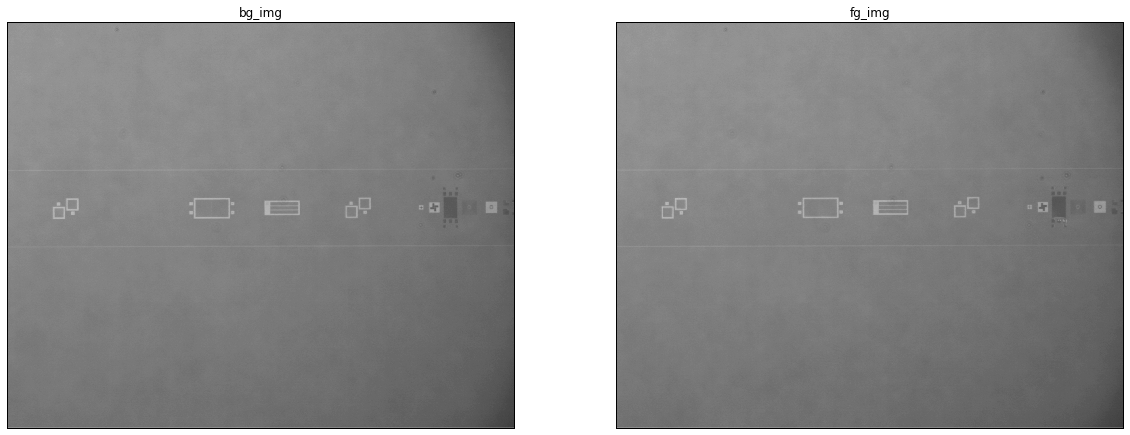

In [29]:
bg_img = cv2.imread(background_file, cv2.IMREAD_GRAYSCALE)
fg_img = cv2.imread(sample_file,     cv2.IMREAD_GRAYSCALE)

rows, cols = bg_img.shape
print rows, cols

util.plot_imgs([(bg_img,'bg_img'), (fg_img, 'fg_img')], max_cols = 2)

In [31]:
def deltaImage(bg_img, fg_img, thresh_val):
    bg_img_blurred = cv2.GaussianBlur(bg_img, (5, 5), 0)
    fg_img_blurred = cv2.GaussianBlur(bg_img, (5, 5), 0)

    delta_image = cv2.absdiff(bg_img_blurred, fg_img_blurred)
    #img_thresh = cv2.adaptiveThreshold(delta_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 5)
    ret,delta_image_thresh = cv2.threshold(delta_image, thresh_val, 255, cv2.THRESH_BINARY)
    return delta_image_thresh


Count non-zero before:  0
Count non-zero after :  0


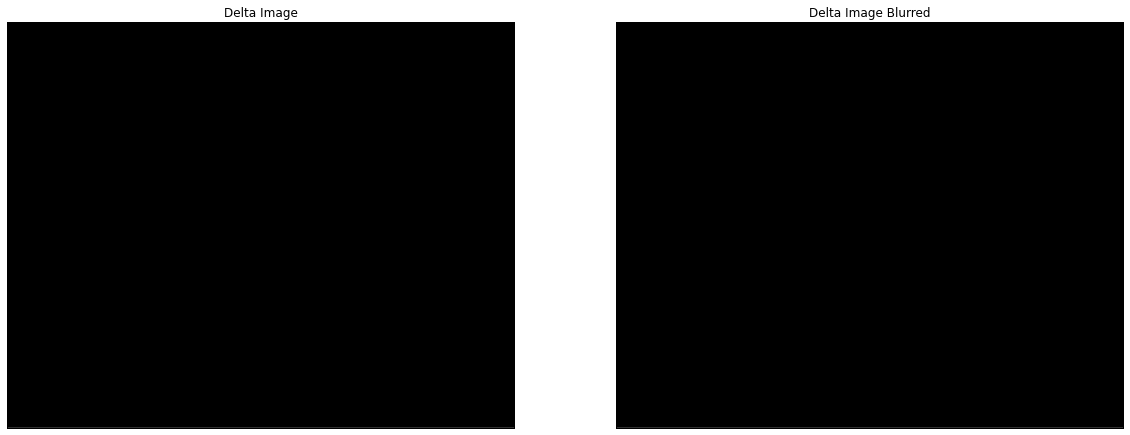

In [36]:
plot_lst = []

# plot_lst.append( (bg_img, 'Background Image'))
# plot_lst.append( (fg_img, 'Foreground Image'))

cum_img = np.zeros(fg_img.shape[:2], np.bool)

#delta_img = cv2.absdiff(bg_img, fg_img)
bg_img_blurred = cv2.GaussianBlur(bg_img, (5, 5), 0)
fg_img_blurred = cv2.GaussianBlur(bg_img, (5, 5), 0)

delta_image = cv2.absdiff(bg_img_blurred, fg_img_blurred)
delta_image = cv2.absdiff(bg_img_blurred, fg_img_blurred)
plot_lst.append( (delta_img, 'Delta Image'))

delta_img_blurred = cv2.GaussianBlur(delta_img, (55, 55), 0)
plot_lst.append( (delta_img_blurred, 'Delta Image Blurred'))

print "Count non-zero before: ", np.count_nonzero(cum_img)
cum_img = np.logical_or(cum_img, delta_img_blurred)
print "Count non-zero after : ", np.count_nonzero(cum_img)

util.plot_imgs(plot_lst, color=False, max_cols = 2)

In [ ]:
def calulateDeltaRatio(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    delta_img = ip.deltaImage(bg_img, fg_img, 5)
    #blue_chan_mean = np.abs(np.mean(blue_chan))
    hist = np.bincount(delta_img.ravel(),minlength=256)
    ratio = float(hist[-1])/float(hist[0])
    return hist[0], hist[1], ratio

In [ ]:
d = stats['deltas']
plt.figure(figsize=(10*2,5))
plt.plot(stats['deltas'][1:])
plt.title('Delta Area')
plt.show()
np.min(d)


In [ ]:
plot_lst = []
fg_num = 1
bg_img = img_lst.images[fg_num-1].copy()
fg_img = img_lst.images[fg_num].copy()

plot_lst.append( (bg_img, 'Background Image'))
plot_lst.append( (fg_img, 'Foreground Image'))

hist = np.bincount(delta_img.ravel(),minlength=256)

plt.plot( hist)

#rects1 = ax.bar(ind, menMeans, width, color='r', yerr=menStd)

blacks = hist[0]
whites = hist[-1]
ratio = float(whites)/float(blacks)

blacks, whites, ratio = calulateDeltaRatio(bg_img, fg_img)
print ("blacks: %d, whites: %d, ratio: %.5f" % (blacks, whites, ratio))

util.plot_imgs(plot_lst, color=False, max_cols = 2)

In [ ]:
plot_lst = []
fg_num = 8
bg_img = img_lst.images[fg_num-1].copy()
fg_img = img_lst.images[fg_num].copy()

img = np.hstack((bg_img, fg_img))

plot_lst.append( (bg_img, 'Background Image'))
plot_lst.append( (fg_img, 'Foreground Image'))
plot_lst.append( (img, 'hstack Image'))

util.plot_imgs(plot_lst, color=False, max_cols = 2)

In [ ]:
video_file_path = '/data/projects/contact_front/MR_NewCam/2015-08-04_DFI28.mp4'

cap = cv2.VideoCapture(video_file_path)

cnt = 0
prev_img = None

ratios = []
while(cap.isOpened()):
    ret, new_img = cap.read()
    cnt += 1
    
    if ret:
        if prev_img == None:
            prev_img = new_img
            continue

        blacks, whites, ratio = calulateDeltaRatio(prev_img, new_img)
        ratios.append(ratio)

print "Done processing ", cnt, " images..."
print "Found ", len(ratios), " data pts:"
plt.figure(figsize=(10*2,5))
plt.plot(ratios, color='b')
plt.title('RGB mean values from center ROI')

### 